In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../src")

In [2]:
from evaluation_utils import autoregressive_cross_validation, one_step_cross_validation
from visualization import plot_last_fold_autoregression, plot_comparison
from models import LastValueRegressor

In [3]:
import pandas as pd
import numpy as np

import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [4]:
data_dir = "../trades_on_sushiswap"
dfs = []
for filename in os.listdir(data_dir):
    df = pd.read_csv(os.path.join(data_dir, filename))
    df.timestamp = pd.to_datetime(df.timestamp, format='%Y-%m-%dT%H:%M:%S.000Z')
    df = df.set_index("timestamp").sort_index()
    df['pair'] = filename[:-4]
    dfs.append(df.drop(['volume', 'isBid'], axis=1))
data = pd.concat(dfs)
data.head()

,price,pair
timestamp,,
2021-05-17 10:27:19,0.000075,CVX_WETH
2021-05-17 10:31:27,0.000084,CVX_WETH
2021-05-17 10:34:51,0.000098,CVX_WETH
2021-05-17 10:36:55,0.000115,CVX_WETH
2021-05-17 13:02:58,0.000129,CVX_WETH


In [5]:
### Global parameters
win_size = 7
k_folds = 5

In [6]:
results = {"autoregressive": {'model': [], 'mean': [], 'stddev': []},\
           "one-step": {'model': [], 'mean': [], 'stddev': []}}

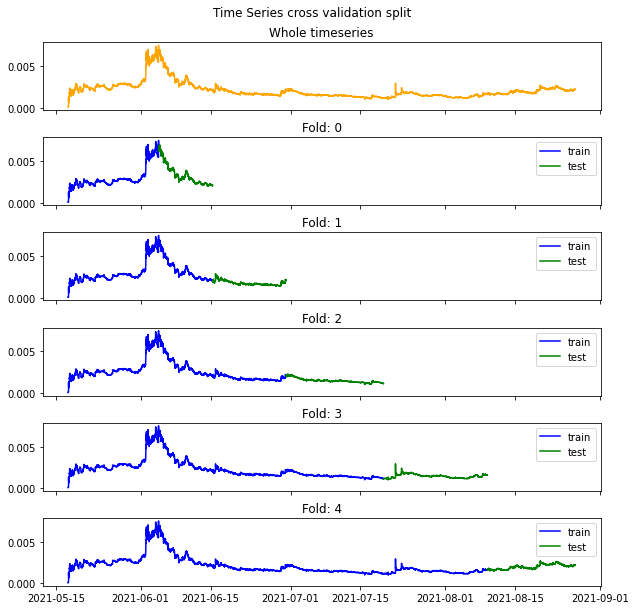

In [7]:
fig, axes = plt.subplots(6, 1, figsize=(10, 10), sharex=True, sharey=True)

# 5 folds cross validation 
ts_cv = TimeSeriesSplit(n_splits=k_folds)

df = data[data.pair == 'CVX_WETH']
axes[0].plot(df.price, color='orange')
axes[0].set_title("Whole timeseries")
for fold, (train_idx, test_idx) in enumerate(ts_cv.split(df.price)):
    axes[fold+1].plot(df.price.iloc[train_idx], color='blue', label='train')
    axes[fold+1].plot(df.price.iloc[test_idx], color='green', label='test')
    axes[fold+1].legend()
    axes[fold+1].set_title(f"Fold: {fold}")
plt.subplots_adjust(hspace=0.4)
plt.suptitle("Time Series cross validation split", y=0.93);

### Dummy baseline - always predict the same price as the one before

In [8]:
PAIRS = ['CVX_WETH', 'AXS_WETH', 'WETH_ZRX', 'UMA_WETH', 'YFI_WETH',
       'WETH_USDT']

In [12]:
df1 = data.copy()
for i in range(1, win_size):
    df1[f"price_{i}"] = data.price.shift(i)
    df1['pair'] = data.pair

y = df1.dropna()[['price', 'pair']]
X = df1.dropna()[[f"price_{i}" for i in range(1, win_size)] + ["pair"]]

In [13]:
X.head()

,price_1,price_2,price_3,price_4,price_5,price_6,pair
timestamp,,,,,,,
2021-05-17 13:20:33,0.000152,0.000129,0.000115,0.000098,0.000084,0.000075,CVX_WETH
2021-05-17 13:20:33,0.000239,0.000152,0.000129,0.000115,0.000098,0.000084,CVX_WETH
2021-05-17 13:20:33,0.000183,0.000239,0.000152,0.000129,0.000115,0.000098,CVX_WETH
2021-05-17 13:21:25,0.000274,0.000183,0.000239,0.000152,0.000129,0.000115,CVX_WETH
2021-05-17 13:22:50,0.000281,0.000274,0.000183,0.000239,0.000152,0.000129,CVX_WETH


In [14]:
y.head()

,price,pair
timestamp,,
2021-05-17 13:20:33,0.000239,CVX_WETH
2021-05-17 13:20:33,0.000183,CVX_WETH
2021-05-17 13:20:33,0.000274,CVX_WETH
2021-05-17 13:21:25,0.000281,CVX_WETH
2021-05-17 13:22:50,0.000321,CVX_WETH


In [15]:
dummy_regressor = LastValueRegressor(win_size=win_size)
model_name = 'dummy regressor'
timeseries_split = TimeSeriesSplit(n_splits=k_folds)
autoreg_cv_errors = autoregressive_cross_validation(dummy_regressor, timeseries_split, X, y, pairs=PAIRS)
onestep_cv_errors = one_step_cross_validation(dummy_regressor, timeseries_split, X, y, pairs=PAIRS)
autoreg_cv_means = autoreg_cv_errors.mean(axis=0)
autoreg_cv_stddevs = autoreg_cv_errors.std(axis=0)
onestep_cv_means = onestep_cv_errors.mean(axis=0)
onestep_cv_stddevs = onestep_cv_errors.std(axis=0)

In [16]:
results = {}
for i, pair in enumerate(PAIRS):
    pair_results = {"autoregressive": {'model': [], 'mean': [], 'stddev': []},\
           "one-step": {'model': [], 'mean': [], 'stddev': []}}
    pair_results['autoregressive']['mean'].append(autoreg_cv_means[i])
    pair_results['autoregressive']['stddev'].append(autoreg_cv_stddevs[i])
    pair_results['one-step']['mean'].append(onestep_cv_means[i])
    pair_results['one-step']['stddev'].append(onestep_cv_stddevs[i])
    pair_results['autoregressive']['model'].append('dummy regressor')
    pair_results['one-step']['model'].append('dummy regressor')
    results[pair] = pair_results

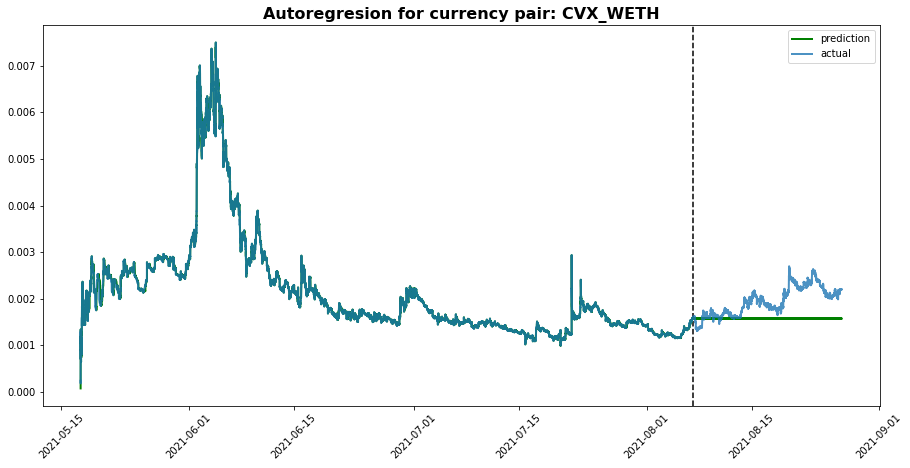

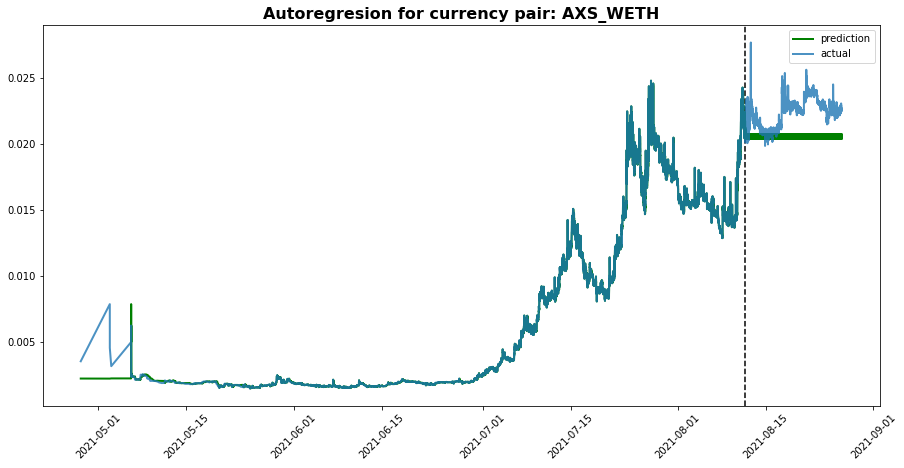

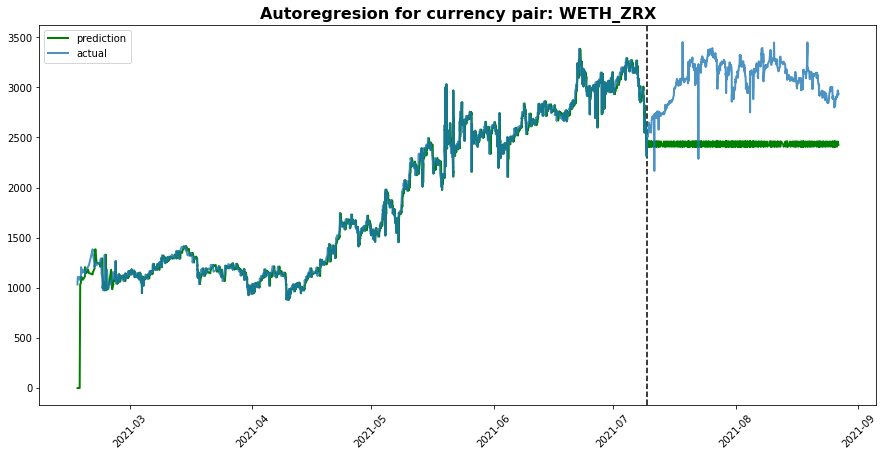

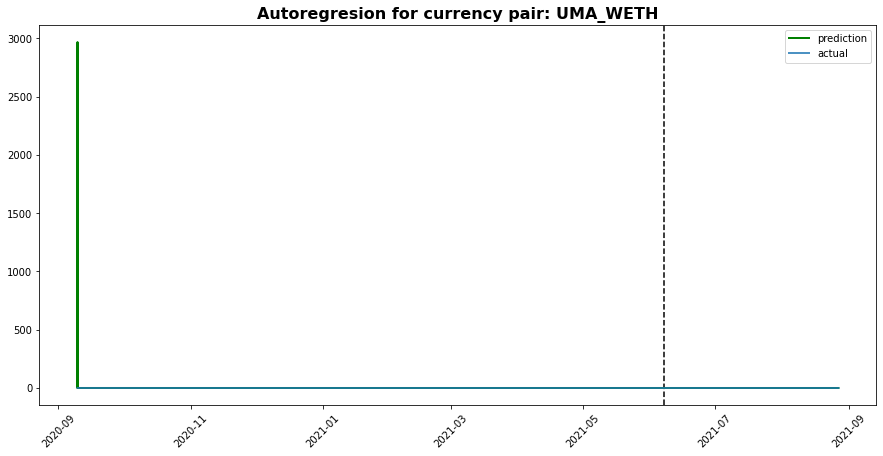

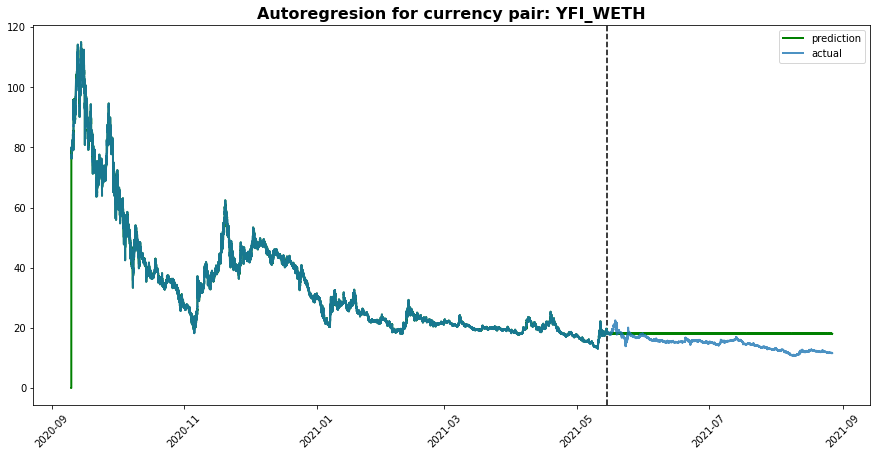

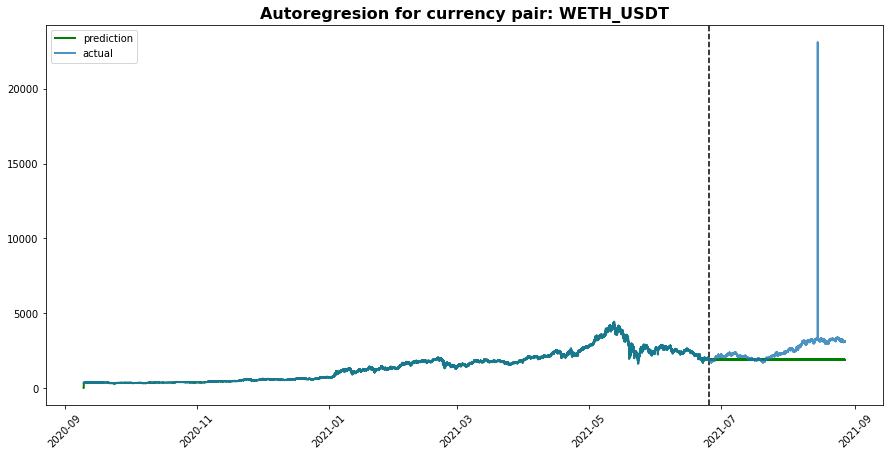

In [17]:
for pair in PAIRS:
    plot_last_fold_autoregression(LastValueRegressor(win_size=win_size),\
                                  X[X.pair == pair].drop('pair', axis=1),\
                                  y[y.pair == pair].drop('pair', axis=1),\
                                  pair=pair)

### Linear Regression based on price only - predicts one step at a time

In [18]:
df1 = data.copy()
for i in range(1, win_size):
    df1[f"price_{i}"] = data.price.shift(i)
    df1['pair'] = data.pair

y = df1.dropna()[['price', 'pair']]
X = df1.dropna()[[f"price_{i}" for i in range(1, win_size)] + ["pair"]]

In [19]:
X.head()

,price_1,price_2,price_3,price_4,price_5,price_6,pair
timestamp,,,,,,,
2021-05-17 13:20:33,0.000152,0.000129,0.000115,0.000098,0.000084,0.000075,CVX_WETH
2021-05-17 13:20:33,0.000239,0.000152,0.000129,0.000115,0.000098,0.000084,CVX_WETH
2021-05-17 13:20:33,0.000183,0.000239,0.000152,0.000129,0.000115,0.000098,CVX_WETH
2021-05-17 13:21:25,0.000274,0.000183,0.000239,0.000152,0.000129,0.000115,CVX_WETH
2021-05-17 13:22:50,0.000281,0.000274,0.000183,0.000239,0.000152,0.000129,CVX_WETH


In [20]:
y.head()

,price,pair
timestamp,,
2021-05-17 13:20:33,0.000239,CVX_WETH
2021-05-17 13:20:33,0.000183,CVX_WETH
2021-05-17 13:20:33,0.000274,CVX_WETH
2021-05-17 13:21:25,0.000281,CVX_WETH
2021-05-17 13:22:50,0.000321,CVX_WETH


In [21]:
lr = LinearRegression()
model_name = 'linear regression price'
timeseries_split = TimeSeriesSplit(n_splits=k_folds)
autoreg_cv_errors = autoregressive_cross_validation(lr, timeseries_split, X, y, pairs=PAIRS)
onestep_cv_errors = one_step_cross_validation(lr, timeseries_split, X, y, pairs=PAIRS)
autoreg_cv_means = autoreg_cv_errors.mean(axis=0)
autoreg_cv_stddevs = autoreg_cv_errors.std(axis=0)
onestep_cv_means = onestep_cv_errors.mean(axis=0)
onestep_cv_stddevs = onestep_cv_errors.std(axis=0)

In [22]:
for i, pair in enumerate(PAIRS):
    pair_results = results[pair]
    pair_results['autoregressive']['mean'].append(autoreg_cv_means[i])
    pair_results['autoregressive']['stddev'].append(autoreg_cv_stddevs[i])
    pair_results['one-step']['mean'].append(onestep_cv_means[i])
    pair_results['one-step']['stddev'].append(onestep_cv_stddevs[i])
    pair_results['autoregressive']['model'].append('linear regression')
    pair_results['one-step']['model'].append('linear regression')

In [23]:
results

{'CVX_WETH': {'autoregressive': {'model': ['dummy regressor',
    'linear regression'],
   'mean': [0.4251073431066338, 70784.03562823063],
   'stddev': [0.2449560967639931, 29005.8260990081]},
  'one-step': {'model': ['dummy regressor', 'linear regression'],
   'mean': [0.018499769148281685, 43.339175275031764],
   'stddev': [0.009661036700720814, 34.14086643354443]}},
 'AXS_WETH': {'autoregressive': {'model': ['dummy regressor',
    'linear regression'],
   'mean': [0.28524370209457783, 10285.904915064919],
   'stddev': [0.20494316701658943, 9239.136137974578]},
  'one-step': {'model': ['dummy regressor', 'linear regression'],
   'mean': [0.015683740277943177, 10.24337657757438],
   'stddev': [0.003374669910612973, 15.208072350333106]}},
 'WETH_ZRX': {'autoregressive': {'model': ['dummy regressor',
    'linear regression'],
   'mean': [0.17337375141996783, 0.2321606296186208],
   'stddev': [0.11501309921302333, 0.19227993952597522]},
  'one-step': {'model': ['dummy regressor', 'linea

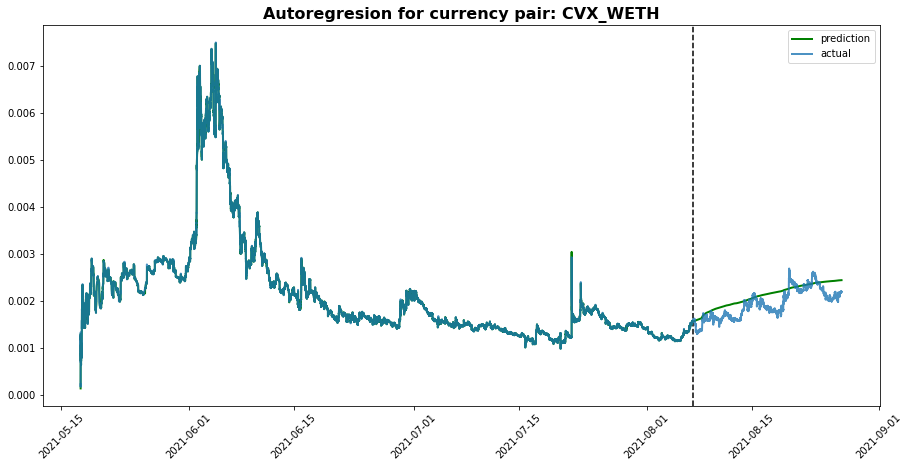

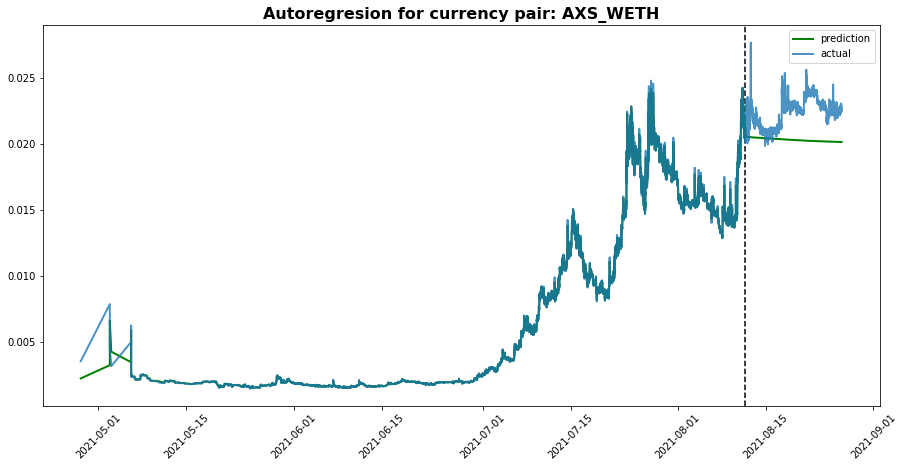

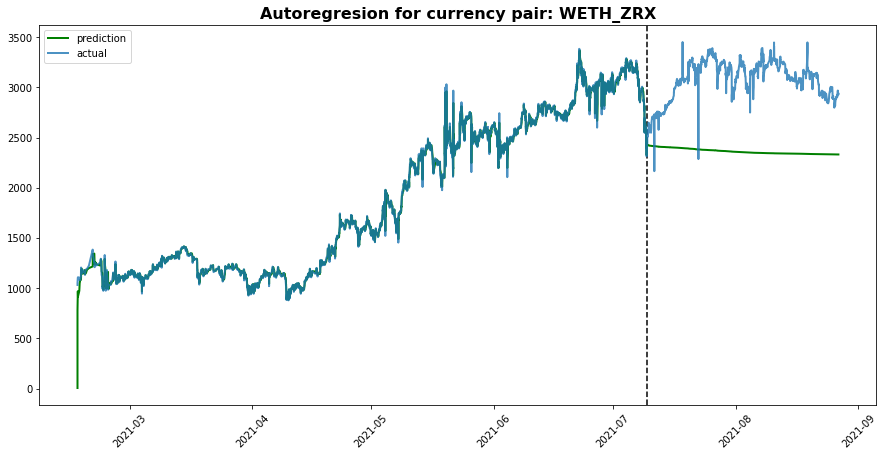

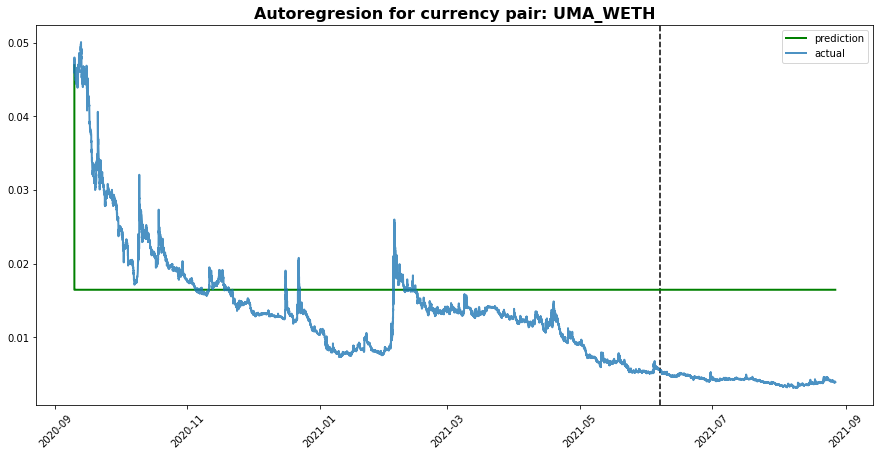

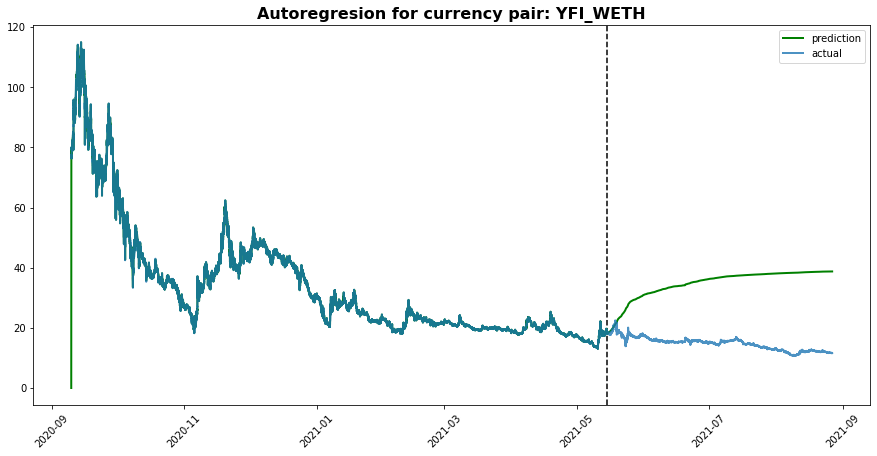

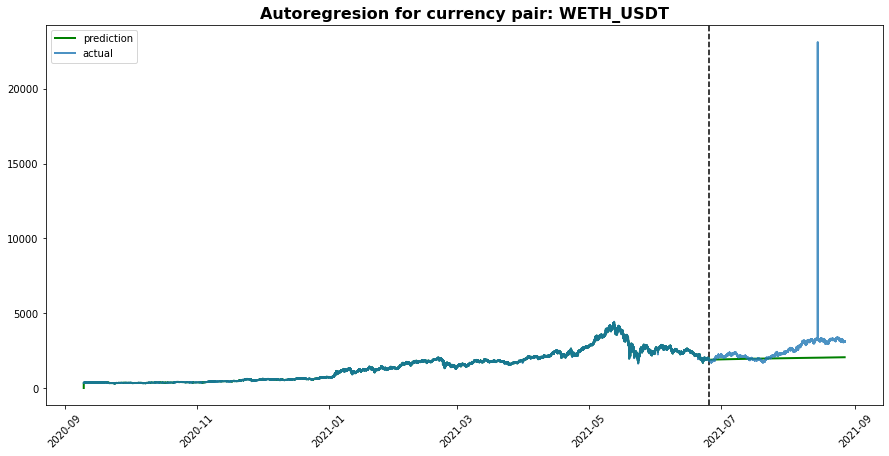

In [24]:
for pair in PAIRS:
    plot_last_fold_autoregression(LinearRegression(),\
                                  X[X.pair == pair].drop('pair', axis=1),\
                                  y[y.pair == pair].drop('pair', axis=1).price,\
                                  pair=pair)

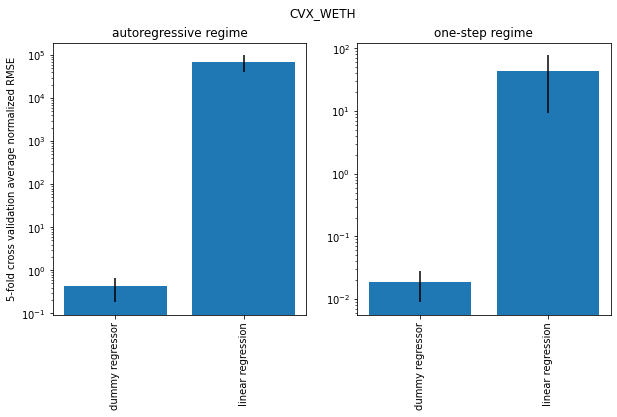

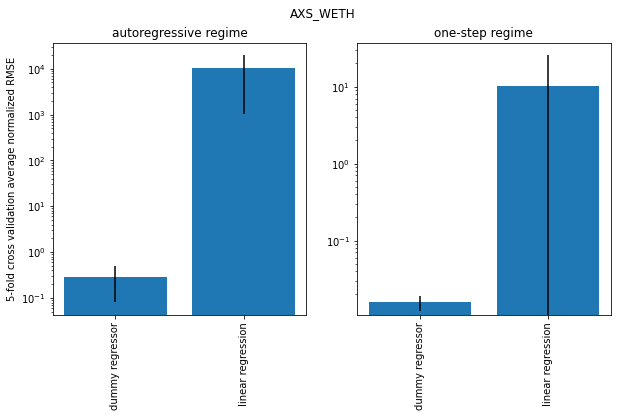

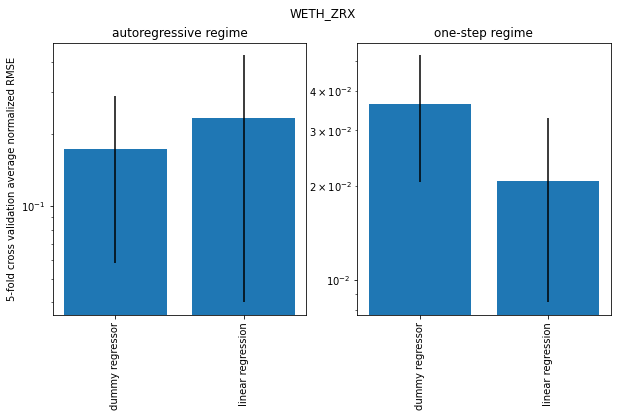

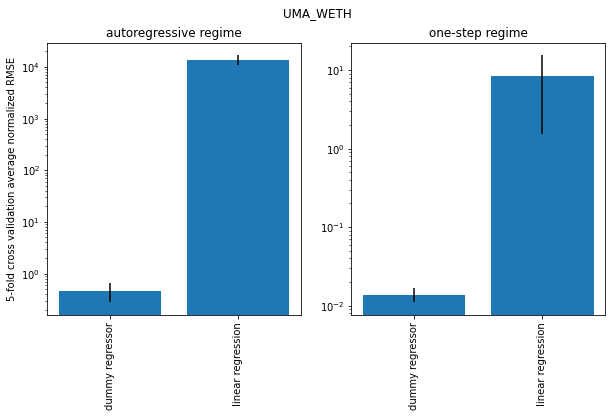

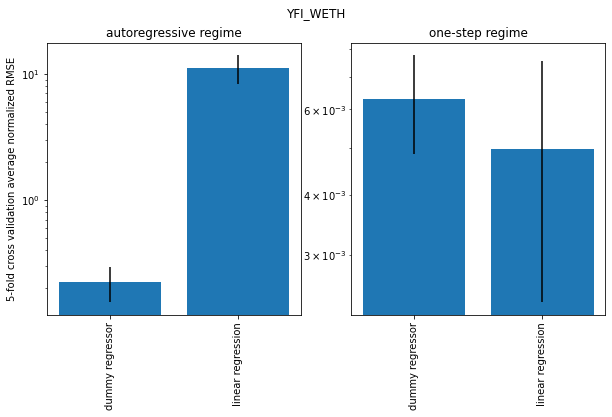

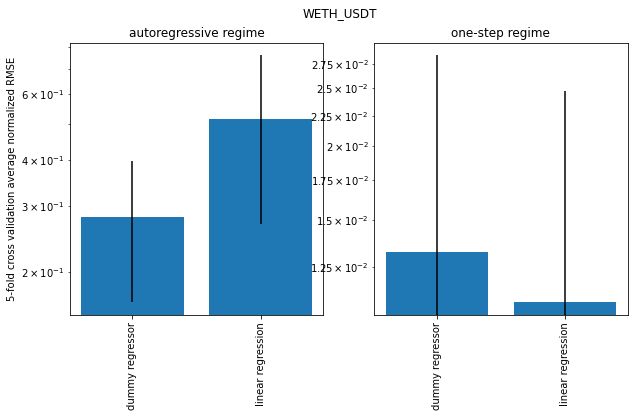

In [25]:
# erorr bars are standard deviations across folds
for pair in PAIRS:
    plot_comparison(results[pair], pair=pair)